In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

In [2]:
# Composite DP Mechanism (1) [https://github.com/CompositeDP/CompositeDP]

def float3f(num):
    return float(format(num, '.3f'))


def float2f(num):
    return float(format(num, '.2f'))


# Constraints

def LValue(ep, k, m, y):
    return (1 - k * m) / (2 * y)

def aValue(ep, k, m, y, Cp):
    return (2 * Cp - k * m ** 2) / (2 * k * m)

def checkConstraints(ep, k, m, y, Cp):
    if k <= 0:
        return -1
    if m <= 0:
        return -2
    if y <= 0:
        return -3

    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)

    if k * m >= 1:
        return -4
    if (Cp > k * m * (2 * L - m) / 2) or (Cp < -k * m * (2 * L - m) / 2):
        return -5
    if k > 1 - y:
        return -6
    if k > y * (np.e ** ep - 1):
        return -7
    
    return 0


# Mapping

def range_Cp_fun(ep, k, m, y):
    L = LValue(ep, k, m, y)
    return k * m * (2 * L - m)

def mapping_fromRealToL(input_value, range_f, lower, ep, k, m, y):
    L = LValue(ep, k, m, y)
    range_Cp = range_Cp_fun(ep, k, m, y)
    C = range_Cp / range_f
    mapped_value = (input_value - lower) * C - L

    return mapped_value

def mapping_inverse_fromLToReal(input_value, range_f, lower, ep, k, m, y):
    L = LValue(ep, k, m, y)
    range_Cp = range_Cp_fun(ep, k, m, y)
    C = range_Cp / range_f
    mapped_inverse_value = (input_value + L) / C + lower

    return mapped_inverse_value

def listmapping_inverse_fromLToReal(input_list, range_f, lower, ep, k, m, y):
    mapped_inverse_list = []
    for i in range(len(input_list)):
        tmp = mapping_inverse_fromLToReal(input_list[i], range_f, lower, ep, k, m, y)
        mapped_inverse_list.append(tmp)
    return mapped_inverse_list


# Parameter Optimization

def reduceRate(var1, var2):
    rate = (var1 - var2) / var1
    return float(rate)

def H1Rate(ep, k, m, y):
    L = LValue(ep, k, m, y)
    S1 = k*m; S2 = 2*L*y
    return float(S2 / S1)

def H2Rate(Cp, ep, k, m, y):
    L = LValue(ep, k, m, y)
    return 0.33333

def theory_var_fun(ep, k, m, y, Cp_assume):
    Cp = Cp_assume
    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)
    variance = -Cp ** 2 + 2 * L ** 3 * y / 3 + a ** 2 * k * m + a * k * m ** 2 + k * m ** 3 / 3
    return float(variance)

def parameter_optimization(ep):
    step1 = 0.1
    step2 = 0.01
    step3 = 0.001
    k_best = 0
    m_best = 0
    y_best = 0
    reduceRate_best = -1000

    y_upper = 1
    k_upper = 1
    m_upper = 2

    # First round step1
    y_count = 0
    while (y_count < y_upper):
        k_count = 0
        while (k_count < k_upper):
            m_count = 0
            while (m_count <= m_upper):
                if y_count == 0:
                    m_count = m_count + step1
                    continue
                range_Cp = range_Cp_fun(ep, k_count, m_count, y_count)
                # Cp_assume = range_Cp / 2
                Cp_assume = 0
                if (checkConstraints(ep, k_count, m_count, y_count, Cp_assume) == 0):
                    var_tmp = theory_var_fun(ep, k_count, m_count, y_count, Cp_assume)
                    var_lap = (range_Cp / ep) ** 2 * 2
                    reduceRate_tmp = reduceRate(var_lap, var_tmp)

                    if (reduceRate_tmp > reduceRate_best):
                        reduceRate_best = reduceRate_tmp
                        k_best = k_count
                        m_best = m_count
                        y_best = y_count

                m_count = m_count + step1
            k_count = k_count + step1
        y_count = y_count + step1

    # Second round step2
    if (y_best == 0):
        y_count = 0
        y_count_end = 0.1
    else:
        y_count = y_best - step1
        y_count_end = y_best + step1
    while (y_count < y_count_end):
        if (k_best == 0):
            k_count = 0
            k_count_end = 0.1
        else:
            k_count = k_best - step1
            k_count_end = k_best + step1
        while (k_count < k_count_end):
            if (m_best == 0):
                m_count = 0
                m_count_end = 0.1
            else:
                m_count = m_best - step1
                m_count_end = m_best + step1
            while (m_count < m_count_end):
                if y_count == 0:
                    m_count = m_count + step2
                    continue
                range_Cp = range_Cp_fun(ep, k_count, m_count, y_count)
                # Cp_assume = range_Cp / 2
                Cp_assume = 0
                if (checkConstraints(ep, k_count, m_count, y_count, Cp_assume) == 0):
                    var_tmp = theory_var_fun(ep, k_count, m_count, y_count, Cp_assume)
                    var_lap = (range_Cp / ep) ** 2 * 2
                    reduceRate_tmp = reduceRate(var_lap, var_tmp)

                    if (reduceRate_tmp > reduceRate_best):
                        reduceRate_best = reduceRate_tmp
                        k_best = k_count
                        m_best = m_count
                        y_best = y_count

                m_count = m_count + step2
            k_count = k_count + step2
        y_count = y_count + step2

    # Third round step3
    if (y_best == 0):
        y_count = 0
        y_count_end = 0.01
    else:
        y_count = y_best - step2
        y_count_end = y_best + step2
    while (y_count < y_count_end):
        if (k_best == 0):
            k_count = 0
            k_count_end = 0.01
        else:
            k_count = k_best - step2
            k_count_end = k_best + step2
        while (k_count < k_count_end):
            if (m_best == 0):
                m_count = 0
                m_count_end = 0.01
            else:
                m_count = m_best - step2
                m_count_end = m_best + step2
            while (m_count < m_count_end):
                if y_count == 0:
                    m_count = m_count + step3
                    continue
                range_Cp = range_Cp_fun(ep, k_count, m_count, y_count)
                # Cp_assume = range_Cp / 2
                Cp_assume = 0
                if (checkConstraints(ep, k_count, m_count, y_count, Cp_assume) == 0):
                    var_tmp = theory_var_fun(ep, k_count, m_count, y_count, Cp_assume)
                    var_lap = (range_Cp / ep) ** 2 * 2
                    reduceRate_tmp = reduceRate(var_lap, var_tmp)

                    if (reduceRate_tmp > reduceRate_best):
                        reduceRate_best = reduceRate_tmp
                        k_best = k_count
                        m_best = m_count
                        y_best = y_count

                m_count = m_count + step3
            k_count = k_count + step3
        y_count = y_count + step3

    return k_best, m_best, y_best


# Perturbation Mechanism

def PDF_fun(x, ep, k, m, y, Cp):
    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)
    P = 0
    if (x >= -L) and (x < a):
        P = y
    if (x >= a) and (x < a + m):
        P = y + k
    if (x >= a + m) and (x <= L):
        P = y
    return float3f(P)

def generate_perturbed_list(ep, k, m, y, Cp):
    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)
    t = (y + k) / np.e ** ep

    divid = 10000
    step = 2 * L / divid
    x_count = -L
    X_axis = []
    P_axis = []
    Perturbed_list = []

    while (x_count <= L):
        P_x = PDF_fun(x_count, ep, k, m, y, Cp)
        P_axis.append(P_x)
        X_axis.append(x_count)
        x_count = x_count + step

    for i in range(len(X_axis)):
        rp = P_axis[i]
        rp = int(rp * 1000)
        for j in range(rp):
            Perturbed_list.append(X_axis[i])

    random.shuffle(Perturbed_list)
    return Perturbed_list

def CDPM(ep, fd, range_f, lower):
    k_best, m_best, y_best = parameter_optimization(ep)
    Cp = mapping_fromRealToL(fd, range_f, lower, ep, k_best, m_best, y_best)
    O_perturbed = generate_perturbed_list(ep, k_best, m_best, y_best, Cp)
    Out_perturbed = listmapping_inverse_fromLToReal(O_perturbed, range_f, lower, ep, k_best, m_best, y_best)

    return Out_perturbed[0]

In [3]:
# Laplace Mechanism

def LM(epsilon, fx, sensitivity):
    z = np.random.laplace(0,sensitivity/epsilon,1)
    return fx+z

In [4]:
# Central Piecewise Mechanism for a numeric query

def eta(c,l,r):
    return (2/r)*c - (2*l+r)/r

def inverse_eta(z,l,r):
    return (r/2)*z + (2*l+r)/2

def CPM(epsilon, fx, l, r, sensitivity):
    # Mapping Step
    t = eta(fx,l,r)
    tild_sensitivity = (2/r)*sensitivity
    m = 0
    while(1):
        if m < 2/tild_sensitivity <= m+1:
            break
        else:
            m += 1
    
    # Perturbation Step
    A = tild_sensitivity*(math.exp(epsilon)*(math.exp(m*epsilon)-1)/(math.exp(epsilon)-1))
    B = (1 + m*tild_sensitivity)*math.exp((m+1)*epsilon)
    U = epsilon/math.log((A + math.sqrt(A**2 + 4*B))/2)
    b = ((m+3)/(m+4))*U
    
    q = (math.exp(epsilon/b)/(2*((math.exp(epsilon/b)+1)**2)*(math.exp(epsilon)-1)))*((math.exp(epsilon)-1)*(math.exp((m+1)*epsilon)-1)-tild_sensitivity*(math.exp(epsilon)/math.exp(epsilon/b))*(m*math.exp((m+1)*epsilon)-(m+1)*math.exp(m*epsilon)+1))
    X = math.exp((m+1)*epsilon)/(2*q*(math.exp(epsilon/b)+1))
    Y = np.zeros(m+2)
    for j in range(1,m+2):
        Y[j] = (1/(2*q))*(math.exp(epsilon/b)/(math.exp(epsilon/b)+1))*(1+tild_sensitivity*(math.exp(epsilon)/math.exp(epsilon/b))*((m+1-j)*math.exp(m*epsilon)-(math.exp(m*epsilon)-1)/(math.exp(epsilon)-1)))
    D = X + Y[1]
    
    u = random.uniform(0,1)
    flag = 0
    if u < (q/math.exp((m+1)*epsilon))*(X*t-Y[1]+D):
        tt = random.uniform(-D,X*t-Y[1])
        flag = 1
    p = (q/math.exp((m+1)*epsilon))*(X*t-Y[1]+D)
    for j in range(1,m+1):
        p += (q/math.exp((m+1-j)*epsilon))*X*tild_sensitivity
        if flag == 0 and u < p:
            tt = random.uniform(X*t-Y[j],X*t-Y[j+1])
            flag = 1
    p += q*2*Y[m+1]
    if flag == 0 and u < p:
        tt = random.uniform(X*t-Y[m+1],X*t+Y[m+1])
        flag = 1
    for j in range(1,m+1):
        p += (q/math.exp(j*epsilon))*X*tild_sensitivity
        if flag == 0 and u < p:
            tt = random.uniform(X*t+Y[m+2-j],X*t+Y[m+1-j])
            flag = 1
    if flag == 0:
        tt = random.uniform(X*t+Y[1],D)
        flag = 1
    
    # Inverse Mapping
    p_fx = inverse_eta(tt,l,r)
    
    return p_fx

In [5]:
def accuracy(m):
    l = 0; r = 1; sensitivity = 1/(m+1)
    diff = np.zeros((9,3))
    epsilon = [i+2 for i in range(9)]
    
    fx = random.uniform(0,1)
    for i in range(9):
        diff[i][0] = math.fabs(CPM(epsilon[i], fx, l, r, sensitivity)-fx)
        diff[i][1] = math.fabs(LM(epsilon[i], fx, sensitivity)-fx)
        diff[i][2] = math.fabs(CDPM(epsilon[i], fx, r, 0)-fx)
    
    return diff

[[0.3418514  0.53542374 0.55710589]
 [0.18287239 0.34176451 0.20812691]
 [0.09246955 0.23743404 0.11189342]
 [0.05402491 0.18560527 0.06317915]
 [0.03723784 0.16060101 0.05597192]
 [0.02338104 0.14359891 0.03495537]
 [0.01630008 0.1126983  0.03283209]
 [0.01202531 0.12997687 0.03157092]
 [0.00964298 0.11734227 0.02687097]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


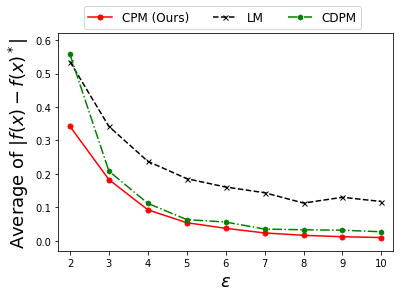

In [6]:
m = 0

diff = np.zeros((9,3))
max_diff = np.zeros((9,3)); min_diff = np.zeros((9,3))
sum_diff = np.zeros((9,3))

jj = 100
for j in range(jj):
    diff = accuracy(m)
    for i in range(9):
        for k in range(3):
            max_diff[i][k] = max(max_diff[i][k], diff[i][k])
            min_diff[i][k] = min(min_diff[i][k], diff[i][k])
            sum_diff[i][k] += diff[i][k]
    #print(diff)
diff = sum_diff/jj

y_err = np.zeros((2,9,3))
for k in range(3):
    y_err[0,:,k] = diff[:,k] - min_diff[:,k]
    y_err[1,:,k] = max_diff[:,k] - diff[:,k]
    
epsilon = [i+2 for i in range(9)]

print(diff)
fig = plt.figure()
plt.ylim(-0.03, 0.62)
plt.xlim(1.7, 10.3)
plt.plot(epsilon, diff[:,0], marker="o", markersize=5, color = "red", linestyle = "-", label = "CPM (Ours)")
plt.plot(epsilon, diff[:,1], marker="x", markersize=5, color = "black", linestyle = "dashed", label = "LM")
plt.plot(epsilon, diff[:,2], marker="h", markersize=5, color = "green", linestyle = "dashdot", label = "CDPM")
#plt.errorbar(epsilon, diff[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='red', markeredgecolor = "red", color='red')
#plt.errorbar(epsilon, diff[:,1], yerr = y_err[:,:,1], capsize=5, fmt='x', ecolor='black', markeredgecolor = "black", color='black')
#plt.errorbar(epsilon, diff[:,2], yerr = y_err[:,:,2], capsize=5, fmt='h', ecolor='green', markeredgecolor = "green", color='green')
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("$\epsilon$", fontsize = 18)
plt.ylabel("Average of $|f(x) - f(x)^*|$", fontsize = 18)
fig.savefig("Accuracy_single_m=0.png")
fig.savefig("figs/Accuracy_single_m=0.eps", bbox_inches="tight", pad_inches=0.05)